In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
np.set_printoptions(precision=2, suppress=False)

import cv2
import pygmsh
import os

spatial_scale = 1e3
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/home/jcolen/envs/sociohydro/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from census_dataset import *
from census_pbnn import *
from skimage.morphology import erosion, dilation, disk

data_dir = '/home/jcolen/data/sociohydro/decennial/revision/'

def make_mesh(county, eps=1e-3, mesh_size=5, dilate=4):
    save_path = f'{data_dir}/meshes/{county}.xml'
    load_path = f'{data_dir}/gridded/{county}.hdf5'

    with h5py.File(load_path, 'r') as h5f:
        d = h5f['2010']
        mask = ~d['county_mask'][:].astype(bool)
        x_grid = d['x_grid'][:] / spatial_scale
        y_grid = d['y_grid'][:] / spatial_scale

    mask_float = np.zeros(mask.shape, dtype=np.uint8)
    mask_float[mask] = 255
    structure = disk(dilate)
    mask_float = dilation(mask_float, structure)
    contours, _ = cv2.findContours(mask_float, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)

    '''
    countours is a list of lists -- you can change the index below here to get 
        different contours to choose as the mesh.
    '''
    idx = np.argmax([contours[i].squeeze().shape[0] for i in range(len(contours))])
    polygon = contours[idx].squeeze()
    
    #Simplify contour
    polygon = cv2.approxPolyDP(polygon, eps*cv2.arcLength(polygon, True), True)
    polygon = polygon.squeeze()
    print(polygon.shape)
    
    print(mask.shape, polygon.shape)
    pos_x = x_grid[polygon[:, 1], polygon[:, 0]]
    pos_y = y_grid[polygon[:, 1], polygon[:, 0]]

    with pygmsh.geo.Geometry() as geom:
        geom.add_polygon(np.stack([pos_x, pos_y], axis=-1), mesh_size=mesh_size)
        mesh = geom.generate_mesh(dim=2, verbose=True)
    mesh.points = mesh.points[:, :2]
    mesh.write(save_path)

    print(mesh)

    fig, ax = plt.subplots(1, 2, dpi=200)
    ax[0].pcolormesh(x_grid, y_grid, mask, cmap='Greys_r')
    ax[1].triplot(mesh.points[:, 0], mesh.points[:, 1], mesh.cells[1].data,
                  color='black', linewidth=0.1)

    for a in ax:
        a.set(xticks=[], yticks=[], title=county, aspect='equal');
    
    try:
        dataset = CensusDataset(county)
        print('Loaded dataset', flush=True)

        model = CensusPBNN()
        model.to(device)

        sample = dataset[0]
        sample['wb0'] = sample['wb0'].to(device)

        loss = model.training_step(sample)[1]
        print(f'Model training step {loss:.3g}')
        if np.isnan(loss):
            print('Loss is bad -- removing mesh from library')
            os.remove(save_path)
        else:
            print('Mesh is alright')
    except Exception as e:
        print(e)
        print('Removing mesh from library')
        os.remove(save_path)

(49, 2)
(457, 526) (49, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 30%] Meshing curve 14 (Line)
Info    : [ 30%] Meshing curve 15 (Line)
Info    : [ 40%] Meshing curve 16 (Line)
Info    : [ 40%] Meshing curve 17 (Line)
Info    : [ 40%] Meshing curve 18 (Line)
Info    : [ 40%] Meshing curve 19 (Line)
Info    : [ 40%] Meshing curve 20 (Line)
Info    : [ 50%] Meshing curve 21 (Line)
Info    : [ 50%] Meshing curve 22 (Line)
Info    : [ 50%] Meshing curve 23 (Line)
Info    : [ 50%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 2057
  Number of cells:
    line: 179
    triangle: 3933
    vertex: 49
Loaded dataset
Model training step 0.00592
Mesh is alright


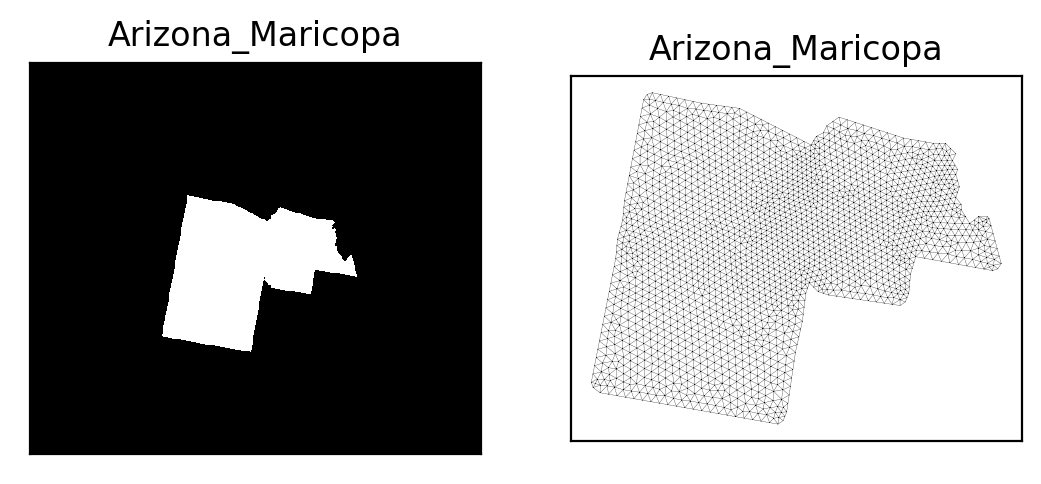

In [3]:
make_mesh('Arizona_Maricopa')

(54, 2)
(170, 178) (54, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 30%] Meshing curve 14 (Line)
Info    : [ 30%] Meshing curve 15 (Line)
Info    : [ 30%] Meshing curve 16 (Line)
Info    : [ 30%] Meshing curve 17 (Line)
Info    : [ 40%] Meshing curve 18 (Line)
Info    : [ 40%] Meshing curve 19 (Line)
Info    : [ 40%] Meshing curve 20 (Line)
Info    : [ 40%] Meshing curve 21 (Line)
Info    : [ 40%] Meshing curve 22 (Line)
Info    : [ 50%] Meshing curve 23 (Line)
Info    : [ 50%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 394
  Number of cells:
    line: 82
    triangle: 704
    vertex: 54
Loaded dataset
Model training step 0.00323
Mesh is alright


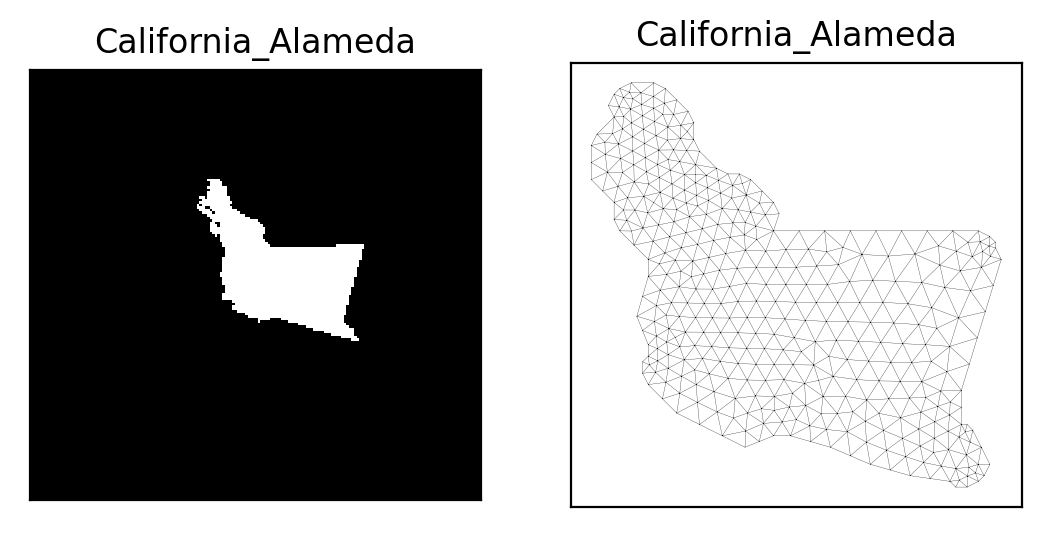

In [4]:
make_mesh('California_Alameda')

(53, 2)
(119, 181) (53, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 30%] Meshing curve 14 (Line)
Info    : [ 30%] Meshing curve 15 (Line)
Info    : [ 30%] Meshing curve 16 (Line)
Info    : [ 40%] Meshing curve 17 (Line)
Info    : [ 40%] Meshing curve 18 (Line)
Info    : [ 40%] Meshing curve 19 (Line)
Info    : [ 40%] Meshing curve 20 (Line)
Info    : [ 40%] Meshing curve 21 (Line)
Info    : [ 40%] Meshing curve 22 (Line)
Info    : [ 50%] Meshing curve 23 (Line)
Info    : [ 50%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 380
  Number of cells:
    line: 73
    triangle: 685
    vertex: 53
Loaded dataset
Model training step 0.0242
Mesh is alright


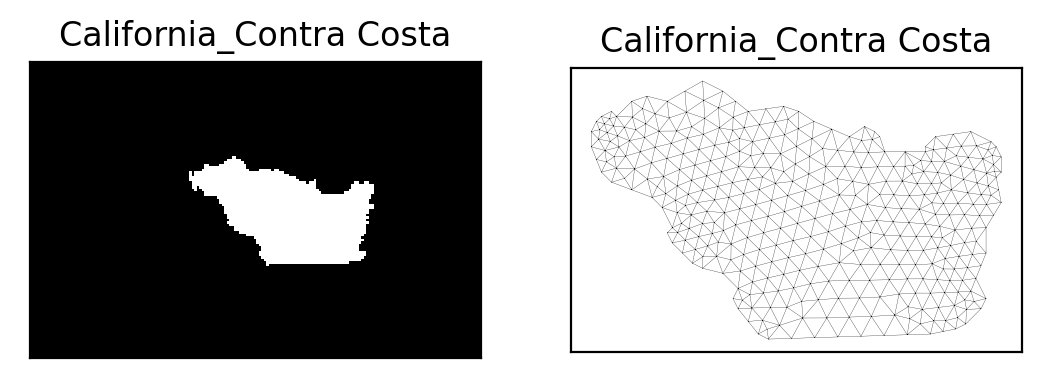

In [5]:
make_mesh('California_Contra Costa')

(68, 2)
(339, 342) (68, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 20%] Meshing curve 14 (Line)
Info    : [ 30%] Meshing curve 15 (Line)
Info    : [ 30%] Meshing curve 16 (Line)
Info    : [ 30%] Meshing curve 17 (Line)
Info    : [ 30%] Meshing curve 18 (Line)
Info    : [ 30%] Meshing curve 19 (Line)
Info    : [ 30%] Meshing curve 20 (Line)
Info    : [ 30%] Meshing curve 21 (Line)
Info    : [ 40%] Meshing curve 22 (Line)
Info    : [ 40%] Meshing curve 23 (Line)
Info    : [ 40%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding vertex, line.

<meshio mesh object>
  Number of points: 1196
  Number of cells:
    line: 130
    triangle: 2260
    vertex: 68
Loaded dataset
Model training step 0.0325
Mesh is alright


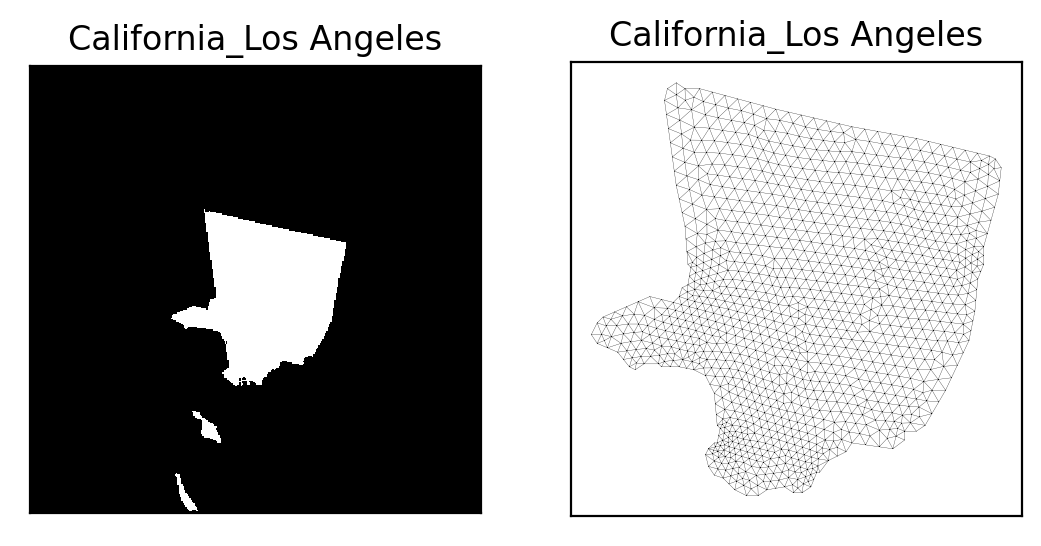

In [23]:
make_mesh('California_Los Angeles')

(55, 2)
(160, 142) (55, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 30%] Meshing curve 14 (Line)
Info    : [ 30%] Meshing curve 15 (Line)
Info    : [ 30%] Meshing curve 16 (Line)
Info    : [ 30%] Meshing curve 17 (Line)
Info    : [ 40%] Meshing curve 18 (Line)
Info    : [ 40%] Meshing curve 19 (Line)
Info    : [ 40%] Meshing curve 20 (Line)
Info    : [ 40%] Meshing curve 21 (Line)
Info    : [ 40%] Meshing curve 22 (Line)
Info    : [ 40%] Meshing curve 23 (Line)
Info    : [ 50%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 505
  Number of cells:
    line: 71
    triangle: 937
    vertex: 55
Loaded dataset
Model training step 0.0214
Mesh is alright


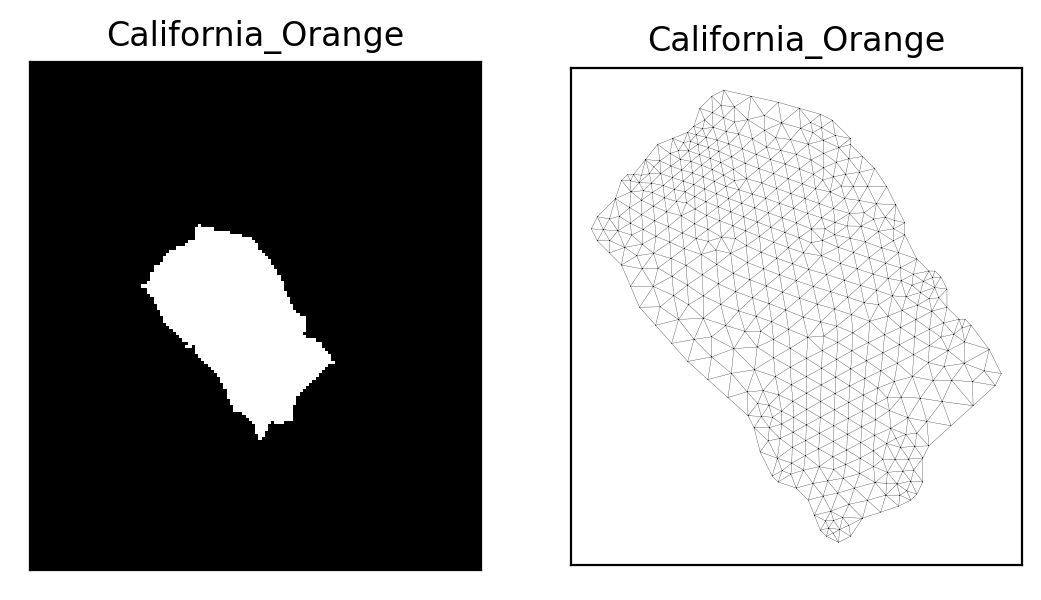

In [6]:
make_mesh('California_Orange')

(62, 2)
(304, 641) (62, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 30%] Meshing curve 14 (Line)
Info    : [ 30%] Meshing curve 15 (Line)
Info    : [ 30%] Meshing curve 16 (Line)
Info    : [ 30%] Meshing curve 17 (Line)
Info    : [ 30%] Meshing curve 18 (Line)
Info    : [ 30%] Meshing curve 19 (Line)
Info    : [ 40%] Meshing curve 20 (Line)
Info    : [ 40%] Meshing curve 21 (Line)
Info    : [ 40%] Meshing curve 22 (Line)
Info    : [ 40%] Meshing curve 23 (Line)
Info    : [ 40%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 1514
  Number of cells:
    line: 172
    triangle: 2854
    vertex: 62
Loaded dataset
Model training step 0.00767
Mesh is alright


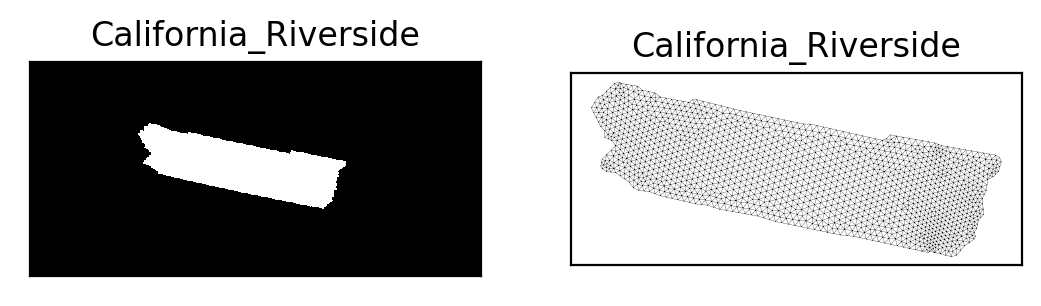

In [7]:
make_mesh('California_Riverside')

(66, 2)
(180, 192) (66, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 20%] Meshing curve 14 (Line)
Info    : [ 30%] Meshing curve 15 (Line)
Info    : [ 30%] Meshing curve 16 (Line)
Info    : [ 30%] Meshing curve 17 (Line)
Info    : [ 30%] Meshing curve 18 (Line)
Info    : [ 30%] Meshing curve 19 (Line)
Info    : [ 30%] Meshing curve 20 (Line)
Info    : [ 40%] Meshing curve 21 (Line)
Info    : [ 40%] Meshing curve 22 (Line)
Info    : [ 40%] Meshing curve 23 (Line)
Info    : [ 40%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 466
  Number of cells:
    line: 96
    triangle: 834
    vertex: 66
Loaded dataset
Model training step 0.000787
Mesh is alright


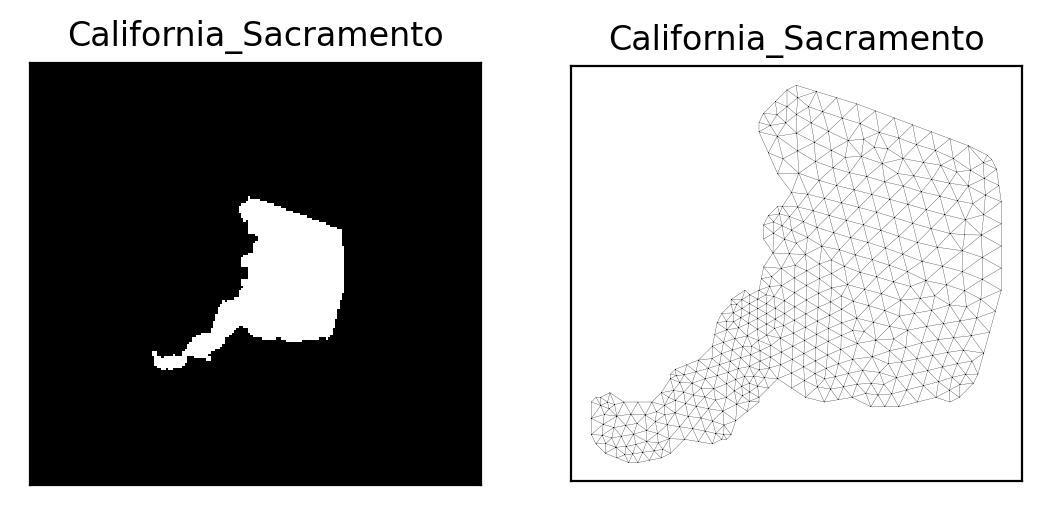

In [8]:
make_mesh('California_Sacramento')

(52, 2)
(625, 804) (52, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 30%] Meshing curve 14 (Line)
Info    : [ 30%] Meshing curve 15 (Line)
Info    : [ 30%] Meshing curve 16 (Line)
Info    : [ 40%] Meshing curve 17 (Line)
Info    : [ 40%] Meshing curve 18 (Line)
Info    : [ 40%] Meshing curve 19 (Line)
Info    : [ 40%] Meshing curve 20 (Line)
Info    : [ 40%] Meshing curve 21 (Line)
Info    : [ 50%] Meshing curve 22 (Line)
Info    : [ 50%] Meshing curve 23 (Line)
Info    : [ 50%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 3301
  Number of cells:
    line: 226
    triangle: 6374
    vertex: 52
Loaded dataset
Model training step 0.00548
Mesh is alright


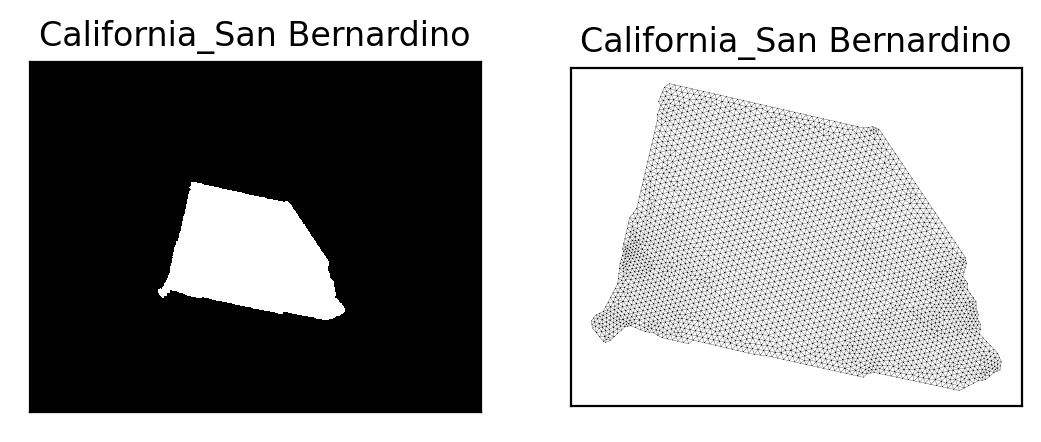

In [9]:
make_mesh('California_San Bernardino')

(51, 2)
(220, 334) (51, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 30%] Meshing curve 14 (Line)
Info    : [ 30%] Meshing curve 15 (Line)
Info    : [ 30%] Meshing curve 16 (Line)
Info    : [ 40%] Meshing curve 17 (Line)
Info    : [ 40%] Meshing curve 18 (Line)
Info    : [ 40%] Meshing curve 19 (Line)
Info    : [ 40%] Meshing curve 20 (Line)
Info    : [ 40%] Meshing curve 21 (Line)
Info    : [ 50%] Meshing curve 22 (Line)
Info    : [ 50%] Meshing curve 23 (Line)
Info    : [ 50%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 921
  Number of cells:
    line: 118
    triangle: 1722
    vertex: 51


Loaded dataset
Model training step 0.00142
Mesh is alright


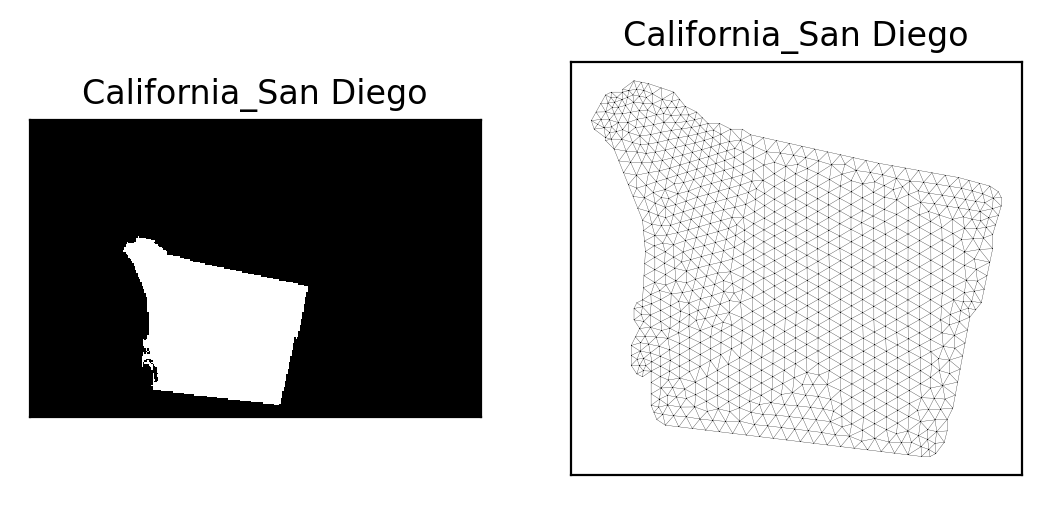

In [10]:
make_mesh('California_San Diego')

(65, 2)
(185, 187) (65, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 20%] Meshing curve 14 (Line)
Info    : [ 30%] Meshing curve 15 (Line)
Info    : [ 30%] Meshing curve 16 (Line)
Info    : [ 30%] Meshing curve 17 (Line)
Info    : [ 30%] Meshing curve 18 (Line)
Info    : [ 30%] Meshing curve 19 (Line)
Info    : [ 30%] Meshing curve 20 (Line)
Info    : [ 40%] Meshing curve 21 (Line)
Info    : [ 40%] Meshing curve 22 (Line)
Info    : [ 40%] Meshing curve 23 (Line)
Info    : [ 40%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 635
  Number of cells:
    line: 86
    triangle: 1182
    vertex: 65
Loaded dataset
Model training step 0.00109
Mesh is alright


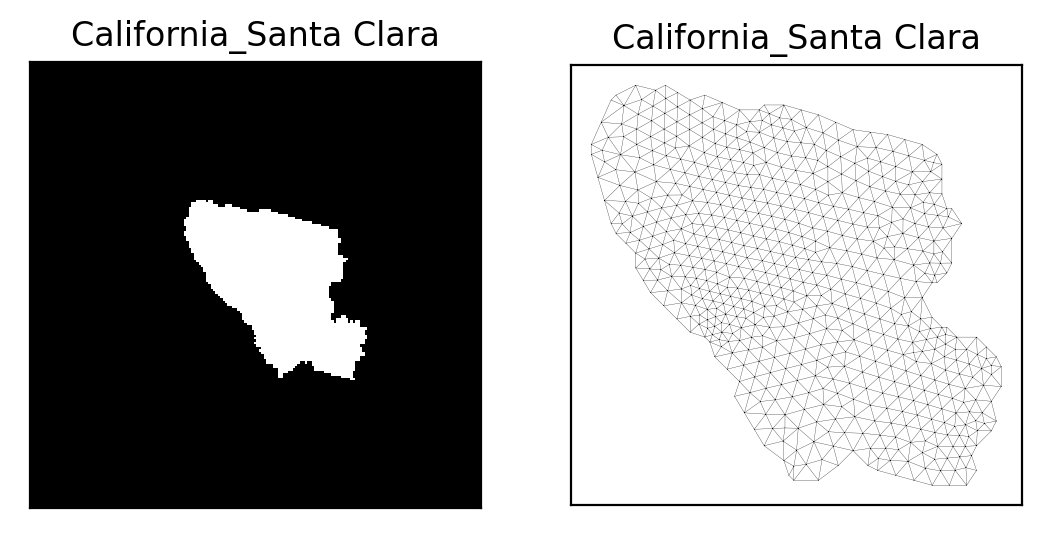

In [11]:
make_mesh('California_Santa Clara')

(36, 2)
(143, 163) (36, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 30%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 40%] Meshing curve 12 (Line)
Info    : [ 40%] Meshing curve 13 (Line)
Info    : [ 40%] Meshing curve 14 (Line)
Info    : [ 40%] Meshing curve 15 (Line)
Info    : [ 50%] Meshing curve 16 (Line)
Info    : [ 50%] Meshing curve 17 (Line)
Info    : [ 50%] Meshing curve 18 (Line)
Info    : [ 50%] Meshing curve 19 (Line)
Info    : [ 60%] Meshing curve 20 (Line)
Info    : [ 60%] Meshing curve 21 (Line)
Info    : [ 60%] Meshing curve 22 (Line)
Info    : [ 70%] Meshing curve 23 (Line)
Info    : [ 70%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 398
  Number of cells:
    line: 68
    triangle: 726
    vertex: 36
Loaded dataset
Model training step 0.000775
Mesh is alright


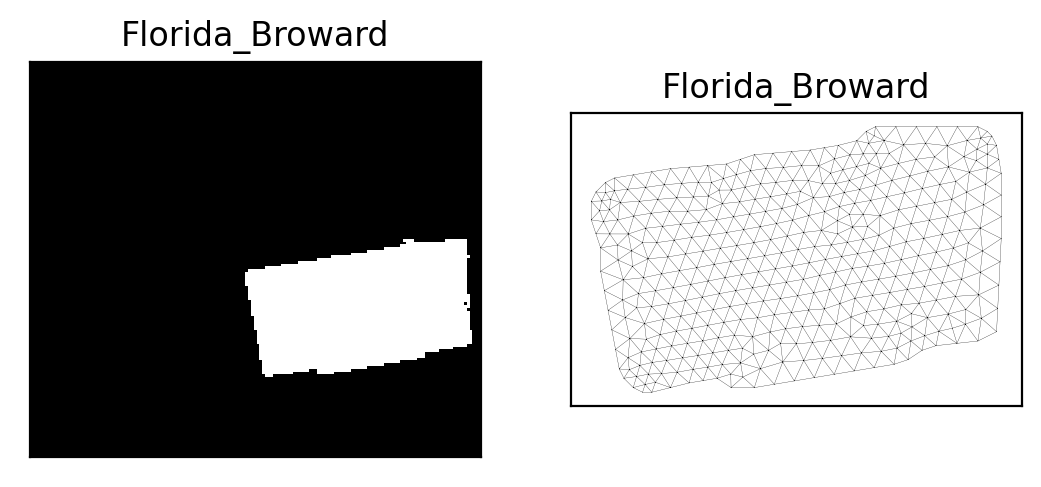

In [12]:
make_mesh('Florida_Broward')

(39, 2)
(183, 129) (39, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 30%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 40%] Meshing curve 13 (Line)
Info    : [ 40%] Meshing curve 14 (Line)
Info    : [ 40%] Meshing curve 15 (Line)
Info    : [ 40%] Meshing curve 16 (Line)
Info    : [ 50%] Meshing curve 17 (Line)
Info    : [ 50%] Meshing curve 18 (Line)
Info    : [ 50%] Meshing curve 19 (Line)
Info    : [ 50%] Meshing curve 20 (Line)
Info    : [ 60%] Meshing curve 21 (Line)
Info    : [ 60%] Meshing curve 22 (Line)
Info    : [ 60%] Meshing curve 23 (Line)
Info    : [ 60%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 368
  Number of cells:
    line: 71
    triangle: 663
    vertex: 39
Loaded dataset
Model training step 0.0402
Mesh is alright


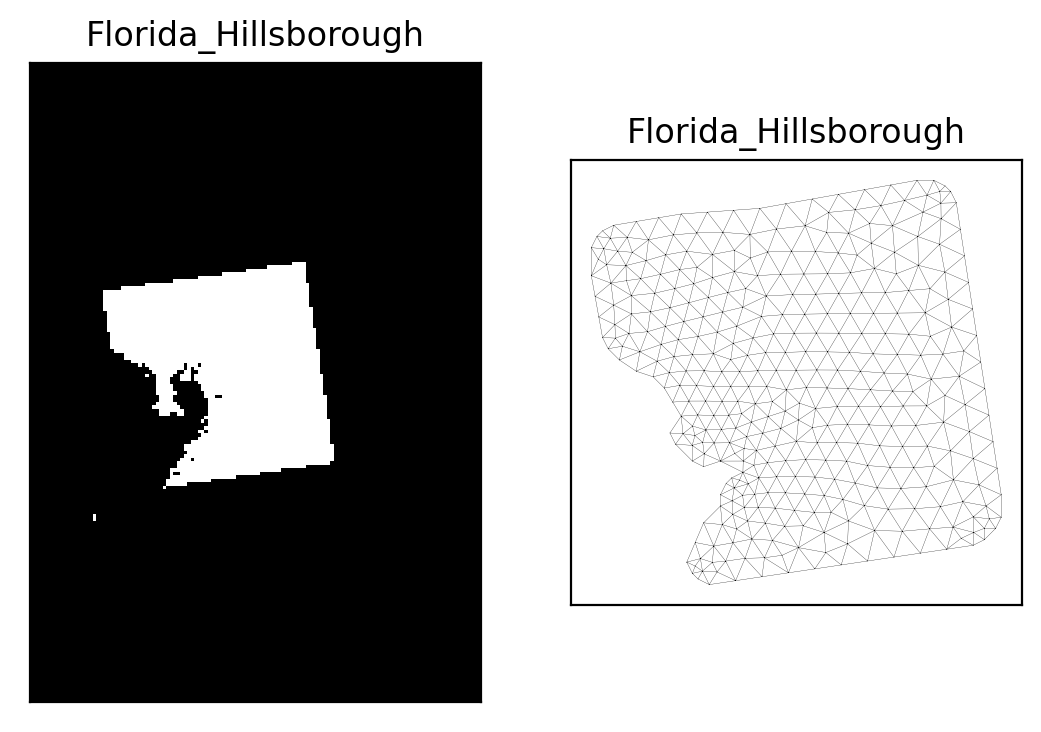

In [13]:
make_mesh('Florida_Hillsborough')

(105, 2)
(305, 236) (105, 2)


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line,
vertex.

<meshio mesh object>
  Number of points: 879
  Number of cells:
    line: 137
    triangle: 1619
    vertex: 105
(12, 3, 305, 236)
Building dataset with constant housing in time
Loaded dataset
Model training step 178
Mesh is alright


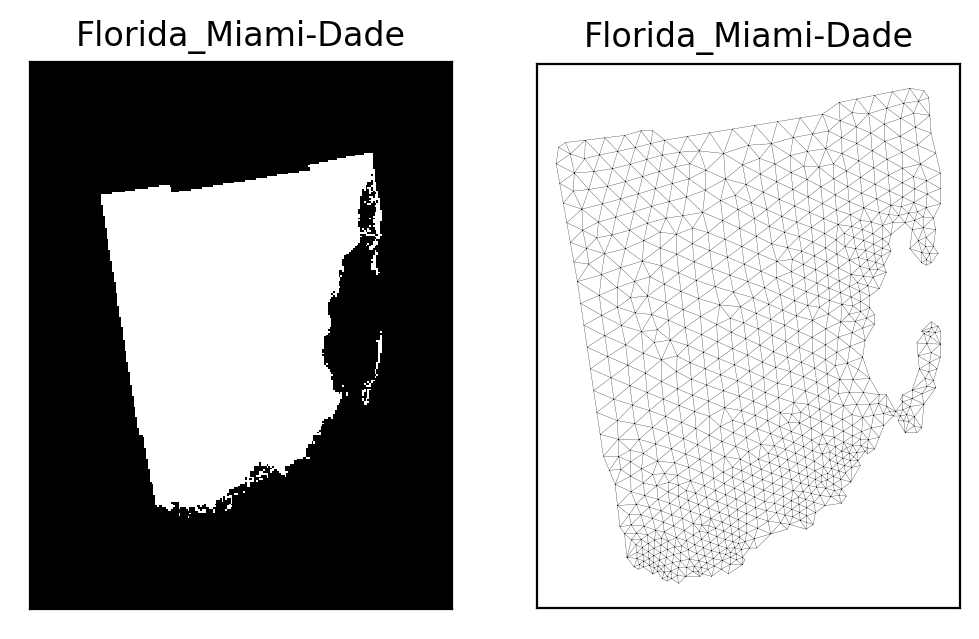

In [15]:
make_mesh('Florida_Miami-Dade')

(32, 2)
(188, 172) (32, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 30%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 40%] Meshing curve 12 (Line)
Info    : [ 40%] Meshing curve 13 (Line)
Info    : [ 50%] Meshing curve 14 (Line)
Info    : [ 50%] Meshing curve 15 (Line)
Info    : [ 50%] Meshing curve 16 (Line)
Info    : [ 50%] Meshing curve 17 (Line)
Info    : [ 60%] Meshing curve 18 (Line)
Info    : [ 60%] Meshing curve 19 (Line)
Info    : [ 60%] Meshing curve 20 (Line)
Info    : [ 70%] Meshing curve 21 (Line)
Info    : [ 70%] Meshing curve 22 (Line)
Info    : [ 70%] Meshing curve 23 (Line)
Info    : [ 80%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 524
  Number of cells:
    line: 80
    triangle: 966
    vertex: 32
Loaded dataset
Model training step 0.0179
Mesh is alright


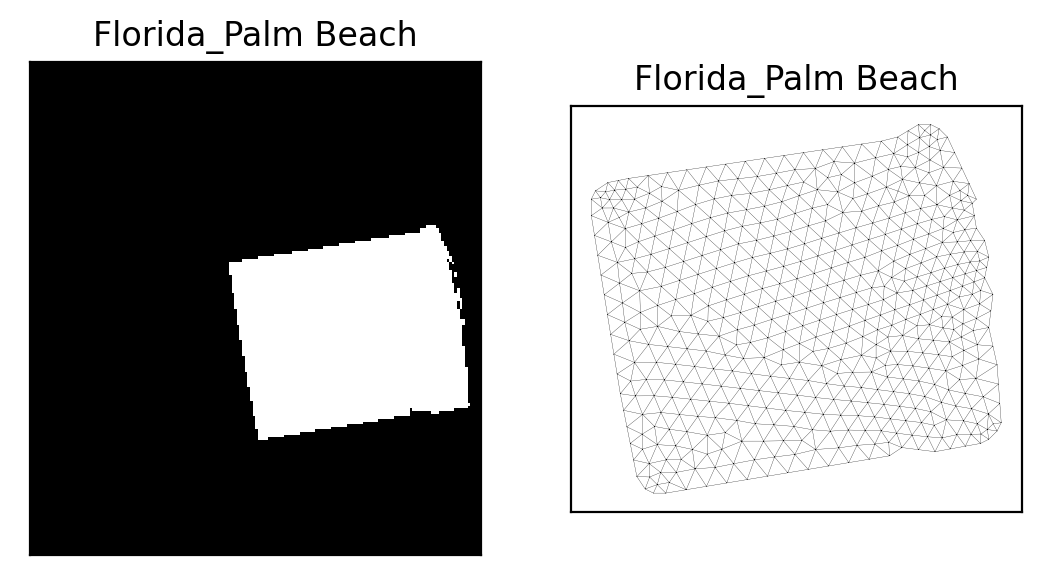

In [14]:
make_mesh('Florida_Palm Beach')

(51, 2)
(169, 150) (51, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 30%] Meshing curve 14 (Line)
Info    : [ 30%] Meshing curve 15 (Line)
Info    : [ 30%] Meshing curve 16 (Line)
Info    : [ 40%] Meshing curve 17 (Line)
Info    : [ 40%] Meshing curve 18 (Line)
Info    : [ 40%] Meshing curve 19 (Line)
Info    : [ 40%] Meshing curve 20 (Line)
Info    : [ 40%] Meshing curve 21 (Line)
Info    : [ 50%] Meshing curve 22 (Line)
Info    : [ 50%] Meshing curve 23 (Line)
Info    : [ 50%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 439
  Number of cells:
    line: 82
    triangle: 794
    vertex: 51
Loaded dataset
Model training step 0.00154
Mesh is alright


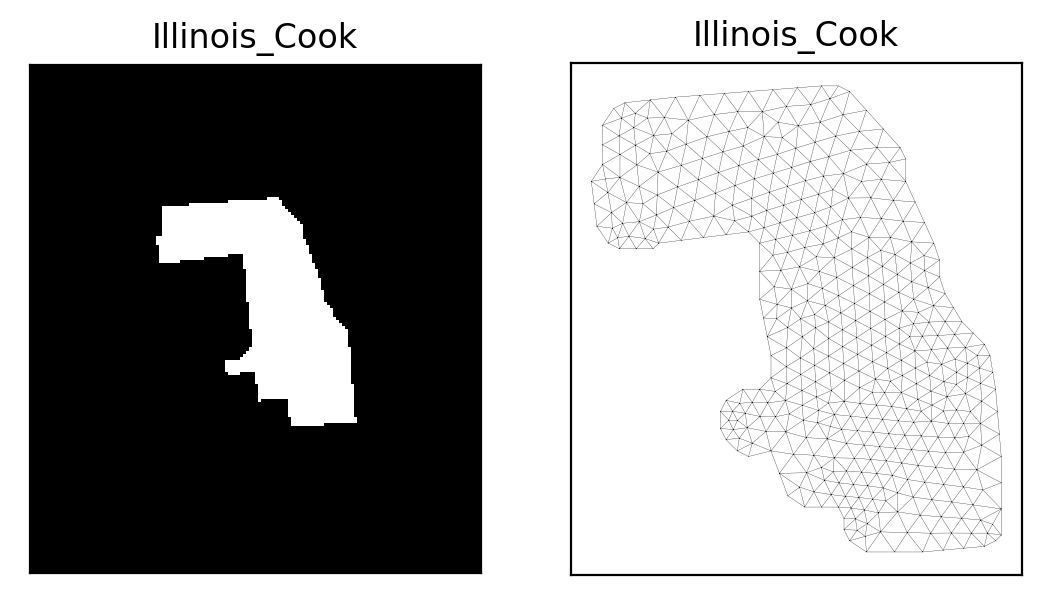

In [15]:
make_mesh('Illinois_Cook')

(72, 2)
(146, 167) (72, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 20%] Meshing curve 14 (Line)
Info    : [ 20%] Meshing curve 15 (Line)
Info    : [ 30%] Meshing curve 16 (Line)
Info    : [ 30%] Meshing curve 17 (Line)
Info    : [ 30%] Meshing curve 18 (Line)
Info    : [ 30%] Meshing curve 19 (Line)
Info    : [ 30%] Meshing curve 20 (Line)
Info    : [ 30%] Meshing curve 21 (Line)
Info    : [ 30%] Meshing curve 22 (Line)
Info    : [ 40%] Meshing curve 23 (Line)
Info    : [ 40%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 518
  Number of cells:
    line: 90
    triangle: 944
    vertex: 72
Loaded dataset
Model training step 0.0342
Mesh is alright


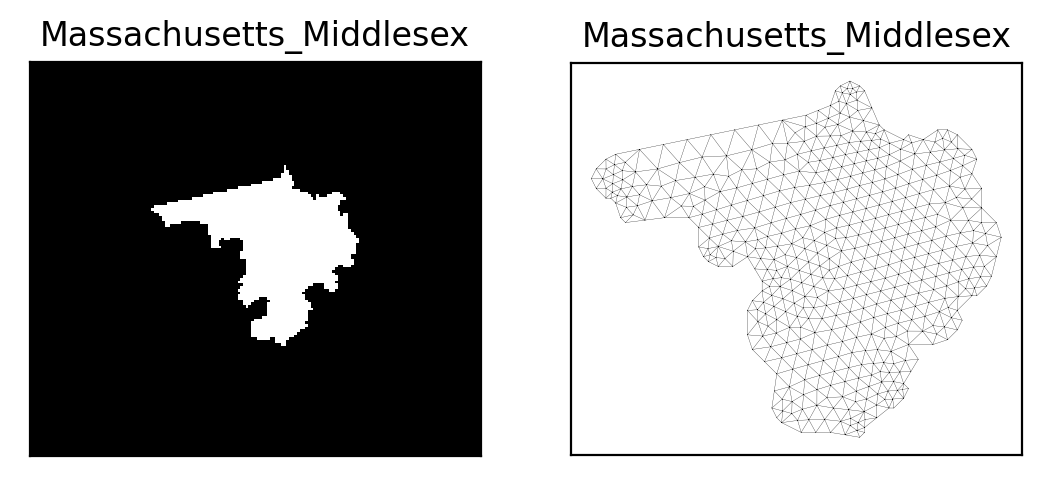

In [16]:
make_mesh('Massachusetts_Middlesex')

(29, 2)
(128, 126) (29, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 40%] Meshing curve 12 (Line)
Info    : [ 50%] Meshing curve 13 (Line)
Info    : [ 50%] Meshing curve 14 (Line)
Info    : [ 50%] Meshing curve 15 (Line)
Info    : [ 60%] Meshing curve 16 (Line)
Info    : [ 60%] Meshing curve 17 (Line)
Info    : [ 60%] Meshing curve 18 (Line)
Info    : [ 70%] Meshing curve 19 (Line)
Info    : [ 70%] Meshing curve 20 (Line)
Info    : [ 70%] Meshing curve 21 (Line)
Info    : [ 80%] Meshing curve 22 (Line)
Info    : [ 80%] Meshing curve 23 (Line)
Info    : [ 80%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 612
  Number of cells:
    line: 84
    triangle: 1138
    vertex: 29
Loaded dataset
Model training step 0.0379
Mesh is alright


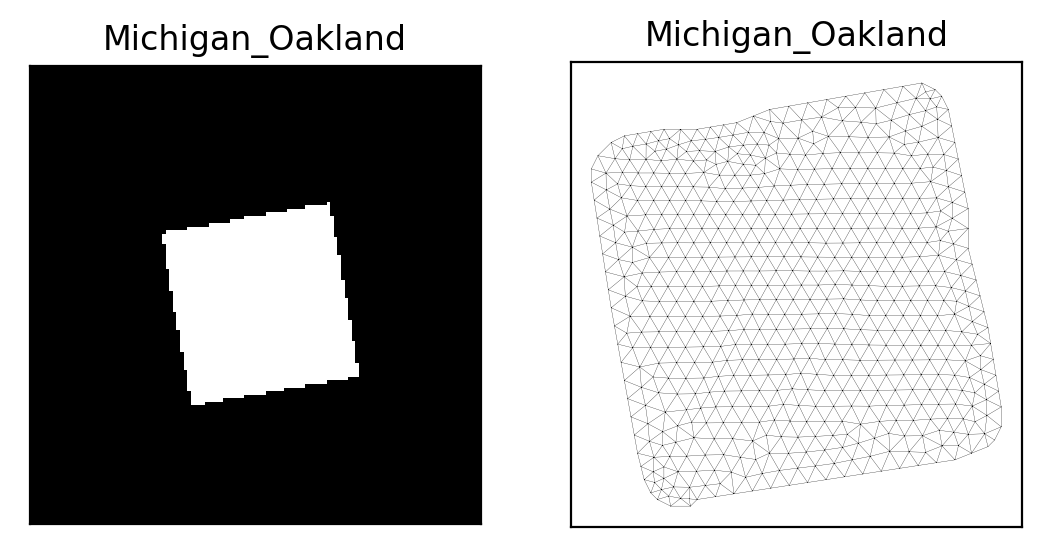

In [17]:
make_mesh('Michigan_Oakland', mesh_size=3)

(44, 2)
(110, 113) (44, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 30%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 30%] Meshing curve 14 (Line)
Info    : [ 40%] Meshing curve 15 (Line)
Info    : [ 40%] Meshing curve 16 (Line)
Info    : [ 40%] Meshing curve 17 (Line)
Info    : [ 40%] Meshing curve 18 (Line)
Info    : [ 50%] Meshing curve 19 (Line)
Info    : [ 50%] Meshing curve 20 (Line)
Info    : [ 50%] Meshing curve 21 (Line)
Info    : [ 50%] Meshing curve 22 (Line)
Info    : [ 50%] Meshing curve 23 (Line)
Info    : [ 60%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 556
  Number of cells:
    line: 90
    triangle: 1020
    vertex: 44
Loaded dataset
Model training step 0.00693
Mesh is alright


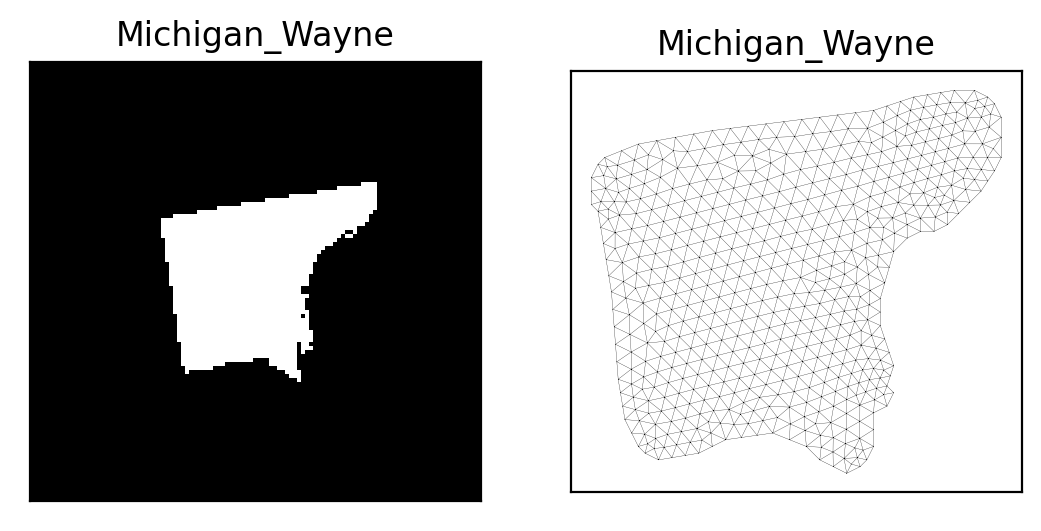

In [18]:
make_mesh('Michigan_Wayne', mesh_size=3)

(43, 2)
(119, 117) (43, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 30%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 40%] Meshing curve 14 (Line)
Info    : [ 40%] Meshing curve 15 (Line)
Info    : [ 40%] Meshing curve 16 (Line)
Info    : [ 40%] Meshing curve 17 (Line)
Info    : [ 40%] Meshing curve 18 (Line)
Info    : [ 50%] Meshing curve 19 (Line)
Info    : [ 50%] Meshing curve 20 (Line)
Info    : [ 50%] Meshing curve 21 (Line)
Info    : [ 50%] Meshing curve 22 (Line)
Info    : [ 60%] Meshing curve 23 (Line)
Info    : [ 60%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 359
  Number of cells:
    line: 60
    triangle: 656
    vertex: 43
Loaded dataset
Model training step 0.0267
Mesh is alright


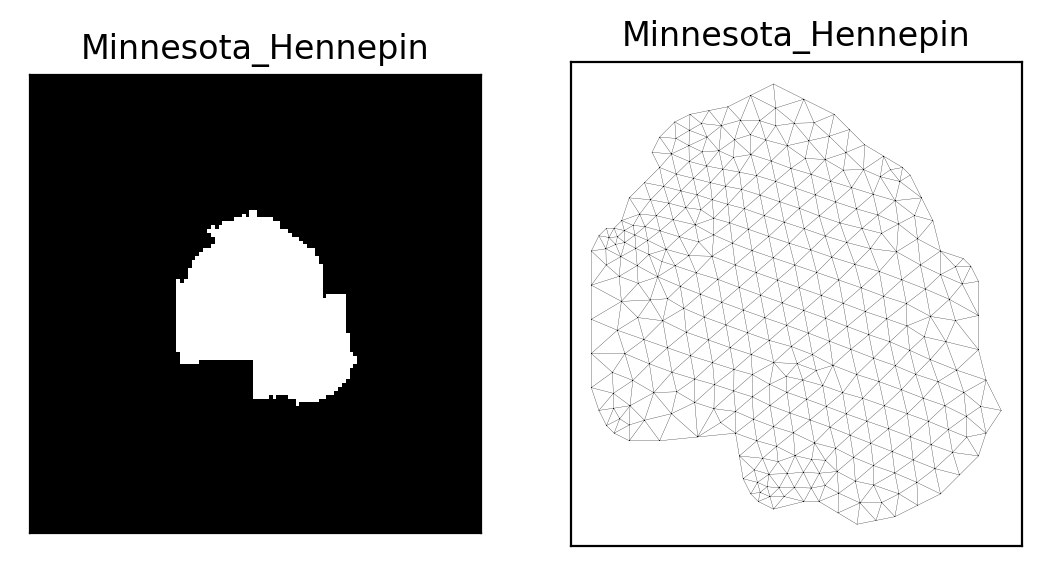

In [19]:
make_mesh('Minnesota_Hennepin')

(57, 2)
(477, 456) (57, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 30%] Meshing curve 14 (Line)
Info    : [ 30%] Meshing curve 15 (Line)
Info    : [ 30%] Meshing curve 16 (Line)
Info    : [ 30%] Meshing curve 17 (Line)
Info    : [ 30%] Meshing curve 18 (Line)
Info    : [ 40%] Meshing curve 19 (Line)
Info    : [ 40%] Meshing curve 20 (Line)
Info    : [ 40%] Meshing curve 21 (Line)
Info    : [ 40%] Meshing curve 22 (Line)
Info    : [ 40%] Meshing curve 23 (Line)
Info    : [ 50%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 1860
  Number of cells:
    line: 172
    triangle: 3546
    vertex: 57
Loaded dataset
Model training step 0.000287
Mesh is alright


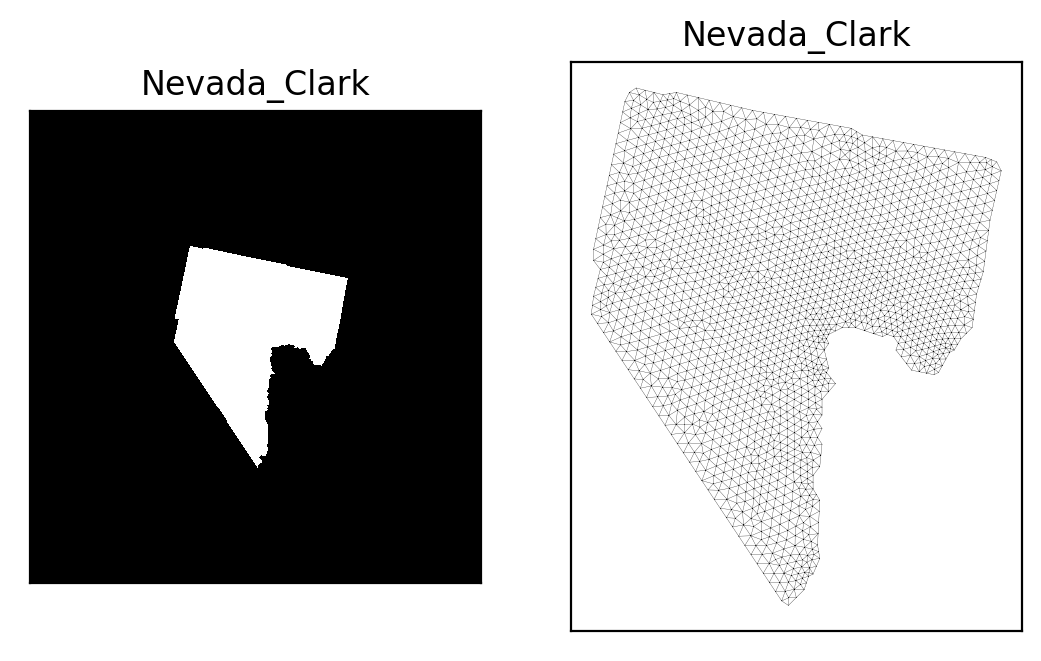

In [20]:
make_mesh('Nevada_Clark')

(15, 2)
(34, 33) (15, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 8 (Line)
Info    : [ 60%] Meshing curve 9 (Line)
Info    : [ 60%] Meshing curve 10 (Line)
Info    : [ 70%] Meshing curve 11 (Line)
Info    : [ 80%] Meshing curve 12 (Line)
Info    : [ 80%] Meshing curve 13 (Line)
Info    : [ 90%] Meshing curve 14 (Line)
Info    : [100%] Meshing curve 15 (Line)
Info    : Done meshing 1D (Wall 0.00322372s, CPU 0.001974s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0102739s, CPU 0.009929s)
Info    : 280 nodes 573 elements


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 280
  Number of cells:
    line: 61
    triangle: 497
    vertex: 15
Loaded dataset
Model training step 0.000307
Mesh is alright


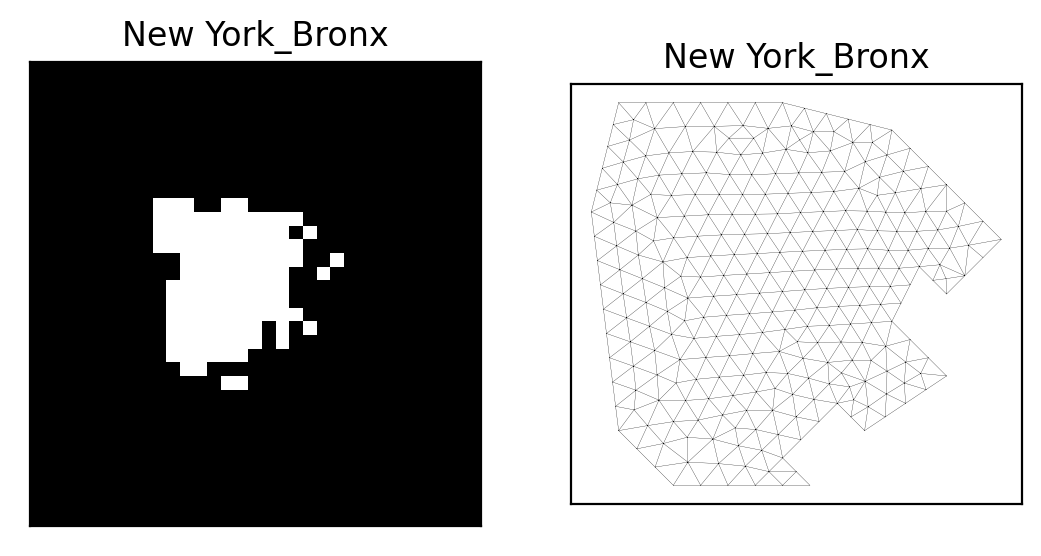

In [21]:
make_mesh('New York_Bronx', dilate=1, mesh_size=1)

(20, 2)
(40, 40) (20, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 40%] Meshing curve 8 (Line)
Info    : [ 40%] Meshing curve 9 (Line)
Info    : [ 50%] Meshing curve 10 (Line)
Info    : [ 50%] Meshing curve 11 (Line)
Info    : [ 60%] Meshing curve 12 (Line)
Info    : [ 60%] Meshing curve 13 (Line)
Info    : [ 70%] Meshing curve 14 (Line)
Info    : [ 70%] Meshing curve 15 (Line)
Info    : [ 80%] Meshing curve 16 (Line)
Info    : [ 80%] Meshing curve 17 (Line)
Info    : [ 90%] Meshing curve 18 (Line)
Info    : [ 90%] Meshing curve 19 (Line)
Info    : [100%] Meshing curve 20 (Line)
Info    : Done meshing 1D (Wall 0.00236306s, CPU 0.002212s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
In

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 426
  Number of cells:
    line: 76
    triangle: 774
    vertex: 20


Loaded dataset
Model training step 0.00298
Mesh is alright


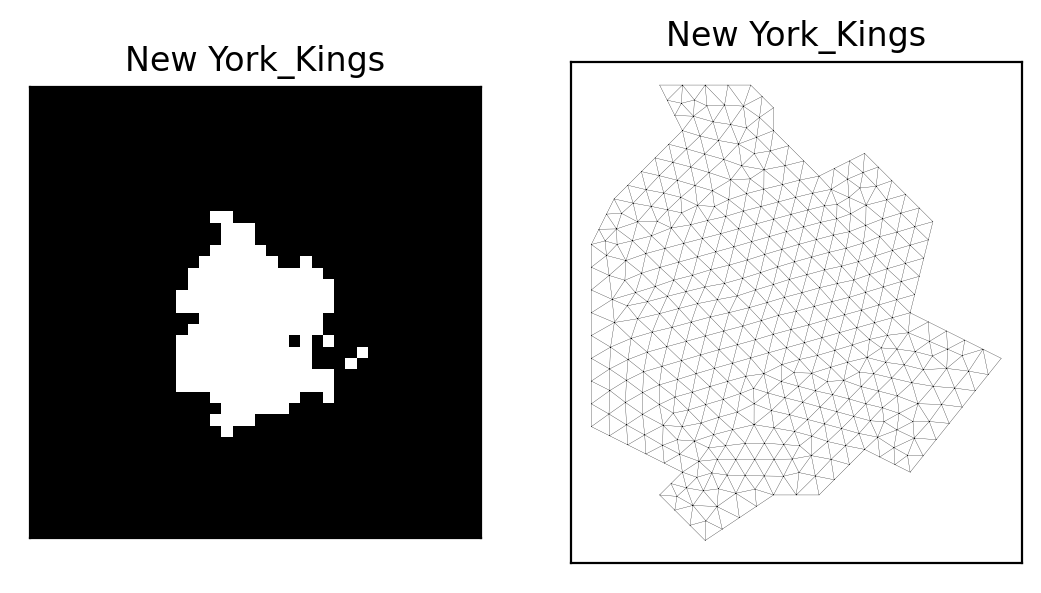

In [22]:
make_mesh('New York_Kings', dilate=1, mesh_size=1)

(32, 2)
(90, 73) (32, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 30%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 40%] Meshing curve 12 (Line)
Info    : [ 40%] Meshing curve 13 (Line)
Info    : [ 50%] Meshing curve 14 (Line)
Info    : [ 50%] Meshing curve 15 (Line)
Info    : [ 50%] Meshing curve 16 (Line)
Info    : [ 50%] Meshing curve 17 (Line)
Info    : [ 60%] Meshing curve 18 (Line)
Info    : [ 60%] Meshing curve 19 (Line)
Info    : [ 60%] Meshing curve 20 (Line)
Info    : [ 70%] Meshing curve 21 (Line)
Info    : [ 70%] Meshing curve 22 (Line)
Info    : [ 70%] Meshing curve 23 (Line)
Info    : [ 80%] 

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 344
  Number of cells:
    line: 62
    triangle: 624
    vertex: 32
Loaded dataset
Model training step 0.0112
Mesh is alright


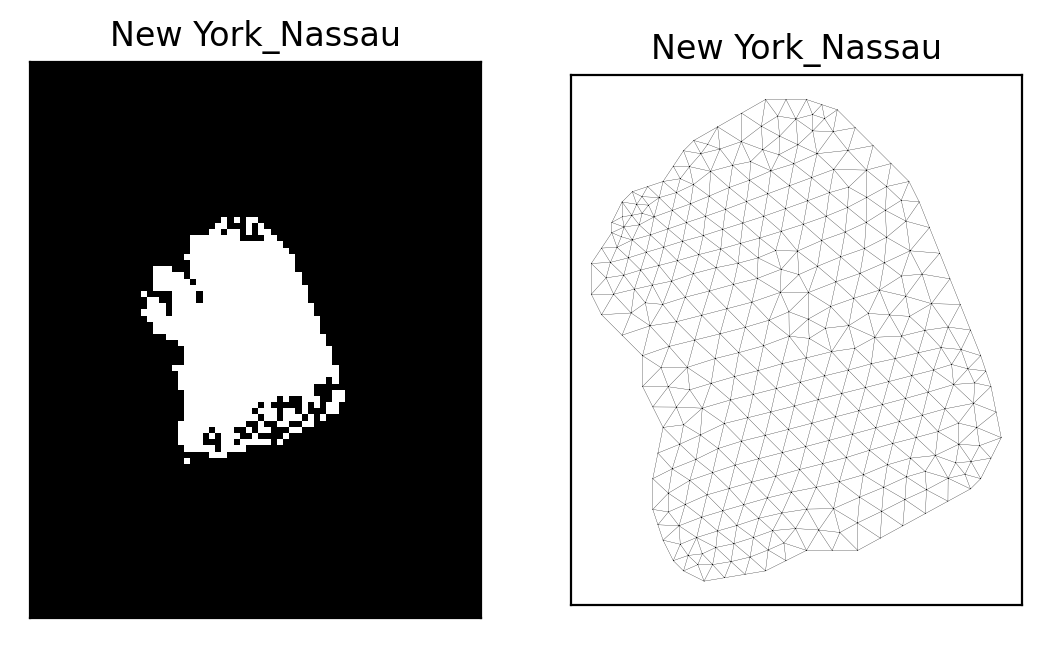

In [23]:
make_mesh('New York_Nassau', mesh_size=3)

(14, 2)
(50, 20) (14, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 40%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 8 (Line)
Info    : [ 60%] Meshing curve 9 (Line)
Info    : [ 70%] Meshing curve 10 (Line)
Info    : [ 80%] Meshing curve 11 (Line)
Info    : [ 80%] Meshing curve 12 (Line)
Info    : [ 90%] Meshing curve 13 (Line)
Info    : [100%] Meshing curve 14 (Line)
Info    : Done meshing 1D (Wall 0.00290017s, CPU 0.001882s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0167624s, CPU 0.016508s)
Info    : 474 nodes 960 elements


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 474
  Number of cells:
    line: 109
    triangle: 837
    vertex: 14
Loaded dataset
Model training step 0.00695
Mesh is alright


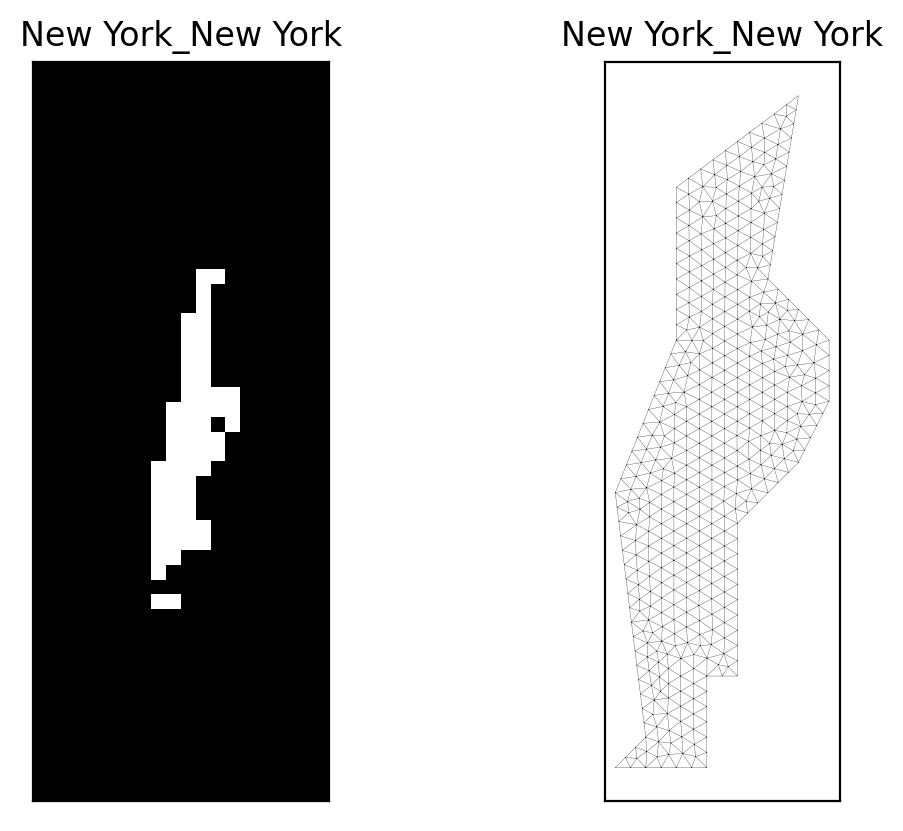

In [24]:
make_mesh('New York_New York', dilate=1, mesh_size=0.5)

(36, 2)
(74, 50) (36, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 30%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 40%] Meshing curve 12 (Line)
Info    : [ 40%] Meshing curve 13 (Line)
Info    : [ 40%] Meshing curve 14 (Line)
Info    : [ 40%] Meshing curve 15 (Line)
Info    : [ 50%] Meshing curve 16 (Line)
Info    : [ 50%] Meshing curve 17 (Line)
Info    : [ 50%] Meshing curve 18 (Line)
Info    : [ 50%] Meshing curve 19 (Line)
Info    : [ 60%] Meshing curve 20 (Line)
Info    : [ 60%] Meshing curve 21 (Line)
Info    : [ 60%] Meshing curve 22 (Line)
Info    : [ 70%] Meshing curve 23 (Line)
Info    : [ 70%] 

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 397
  Number of cells:
    line: 78
    triangle: 714
    vertex: 36


Loaded dataset
Model training step 0.00644
Mesh is alright


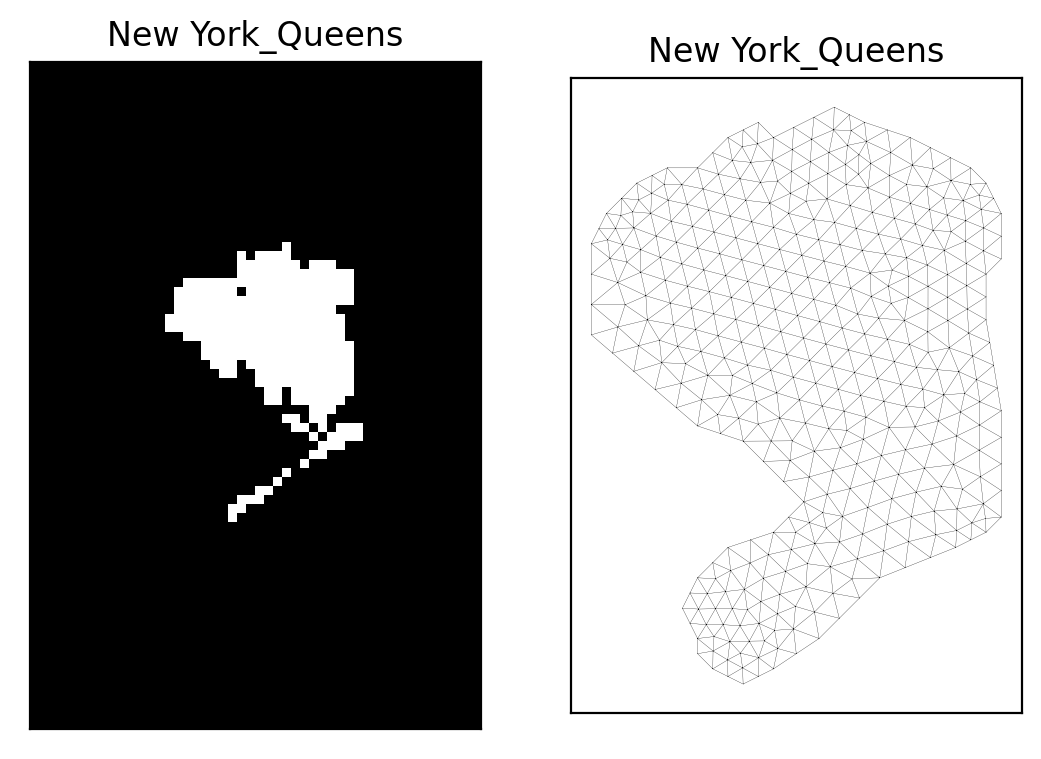

In [25]:
make_mesh('New York_Queens', mesh_size=2)

(71, 2)
(222, 260) (71, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 20%] Meshing curve 14 (Line)
Info    : [ 20%] Meshing curve 15 (Line)
Info    : [ 30%] Meshing curve 16 (Line)
Info    : [ 30%] Meshing curve 17 (Line)
Info    : [ 30%] Meshing curve 18 (Line)
Info    : [ 30%] Meshing curve 19 (Line)
Info    : [ 30%] Meshing curve 20 (Line)
Info    : [ 30%] Meshing curve 21 (Line)
Info    : [ 30%] Meshing curve 22 (Line)
Info    : [ 40%] Meshing curve 23 (Line)
Info    : [ 40%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 492
  Number of cells:
    line: 111
    triangle: 871
    vertex: 71
Loaded dataset
Model training step 0.0192
Mesh is alright


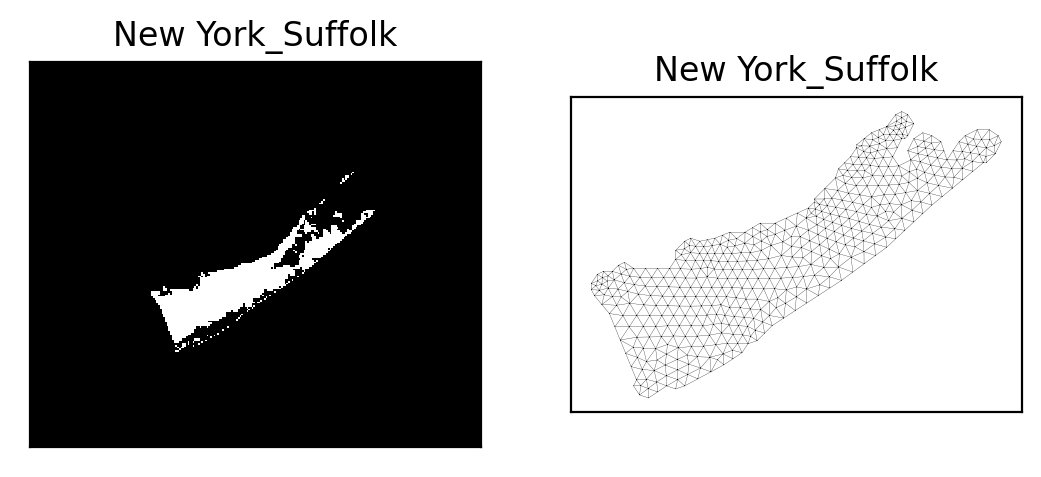

In [26]:
make_mesh('New York_Suffolk')

(48, 2)
(99, 112) (48, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 30%] Meshing curve 14 (Line)
Info    : [ 30%] Meshing curve 15 (Line)
Info    : [ 40%] Meshing curve 16 (Line)
Info    : [ 40%] Meshing curve 17 (Line)
Info    : [ 40%] Meshing curve 18 (Line)
Info    : [ 40%] Meshing curve 19 (Line)
Info    : [ 40%] Meshing curve 20 (Line)
Info    : [ 50%] Meshing curve 21 (Line)
Info    : [ 50%] Meshing curve 22 (Line)
Info    : [ 50%] Meshing curve 23 (Line)
Info    : [ 50%]

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 309
  Number of cells:
    line: 64
    triangle: 552
    vertex: 48
Loaded dataset
Model training step 0.00287
Mesh is alright


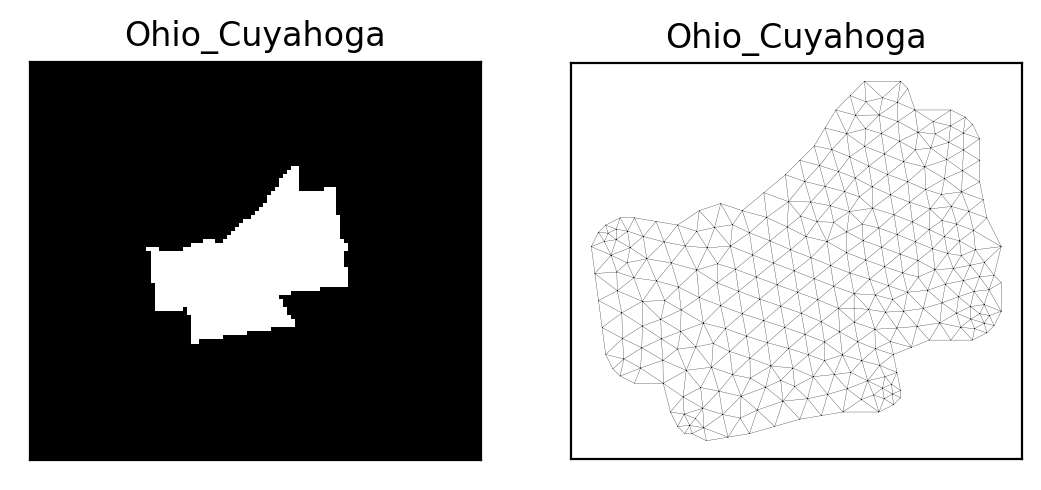

In [27]:
make_mesh('Ohio_Cuyahoga')

(45, 2)
(124, 123) (45, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 30%] Meshing curve 14 (Line)
Info    : [ 40%] Meshing curve 15 (Line)
Info    : [ 40%] Meshing curve 16 (Line)
Info    : [ 40%] Meshing curve 17 (Line)
Info    : [ 40%] Meshing curve 18 (Line)
Info    : [ 40%] Meshing curve 19 (Line)
Info    : [ 50%] Meshing curve 20 (Line)
Info    : [ 50%] Meshing curve 21 (Line)
Info    : [ 50%] Meshing curve 22 (Line)
Info    : [ 50%] Meshing curve 23 (Line)
Info    : [ 60%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 350
  Number of cells:
    line: 65
    triangle: 633
    vertex: 45


Loaded dataset
Model training step 0.000214
Mesh is alright


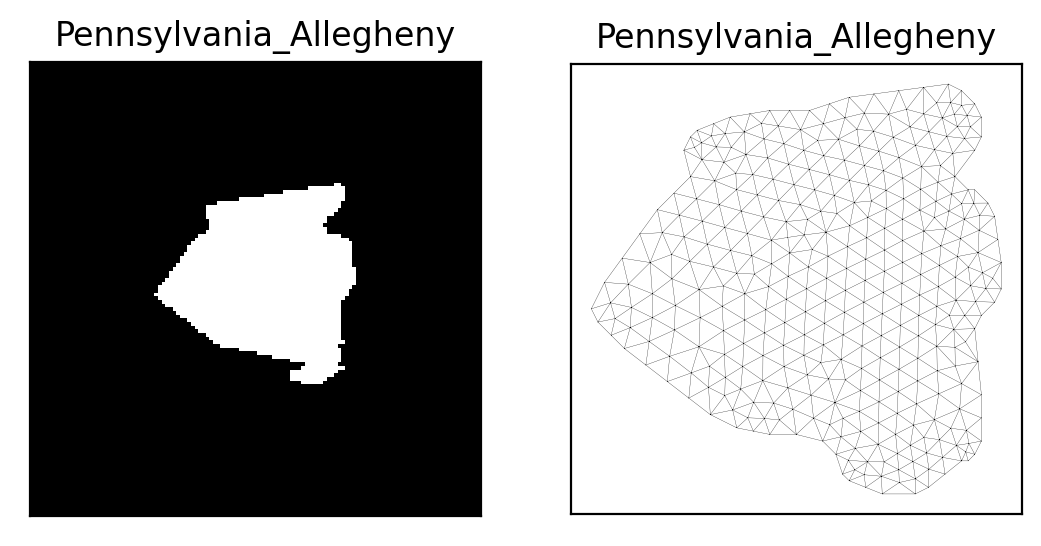

In [28]:
make_mesh('Pennsylvania_Allegheny')

(30, 2)
(76, 59) (30, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 30%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 40%] Meshing curve 12 (Line)
Info    : [ 40%] Meshing curve 13 (Line)
Info    : [ 50%] Meshing curve 14 (Line)
Info    : [ 50%] Meshing curve 15 (Line)
Info    : [ 50%] Meshing curve 16 (Line)
Info    : [ 60%] Meshing curve 17 (Line)
Info    : [ 60%] Meshing curve 18 (Line)
Info    : [ 60%] Meshing curve 19 (Line)
Info    : [ 70%] Meshing curve 20 (Line)
Info    : [ 70%] Meshing curve 21 (Line)
Info    : [ 70%] Meshing curve 22 (Line)
Info    : [ 80%] Meshing curve 23 (Line)
Info    : [ 80%] 

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 448
  Number of cells:
    line: 76
    triangle: 818
    vertex: 30
Loaded dataset
Model training step 0.00708
Mesh is alright


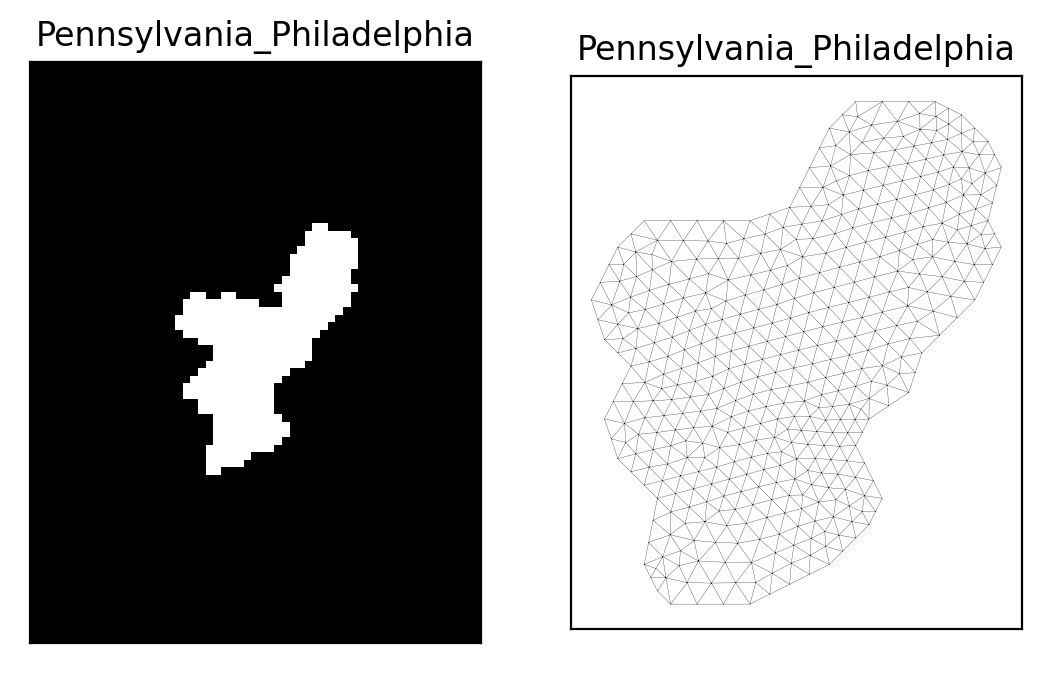

In [29]:
make_mesh('Pennsylvania_Philadelphia', dilate=4, eps=5e-4, mesh_size=2)

(43, 2)
(173, 160) (43, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 30%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 40%] Meshing curve 14 (Line)
Info    : [ 40%] Meshing curve 15 (Line)
Info    : [ 40%] Meshing curve 16 (Line)
Info    : [ 40%] Meshing curve 17 (Line)
Info    : [ 40%] Meshing curve 18 (Line)
Info    : [ 50%] Meshing curve 19 (Line)
Info    : [ 50%] Meshing curve 20 (Line)
Info    : [ 50%] Meshing curve 21 (Line)
Info    : [ 50%] Meshing curve 22 (Line)
Info    : [ 60%] Meshing curve 23 (Line)
Info    : [ 60%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 387
  Number of cells:
    line: 72
    triangle: 700
    vertex: 43
Loaded dataset
Model training step 0.0011
Mesh is alright


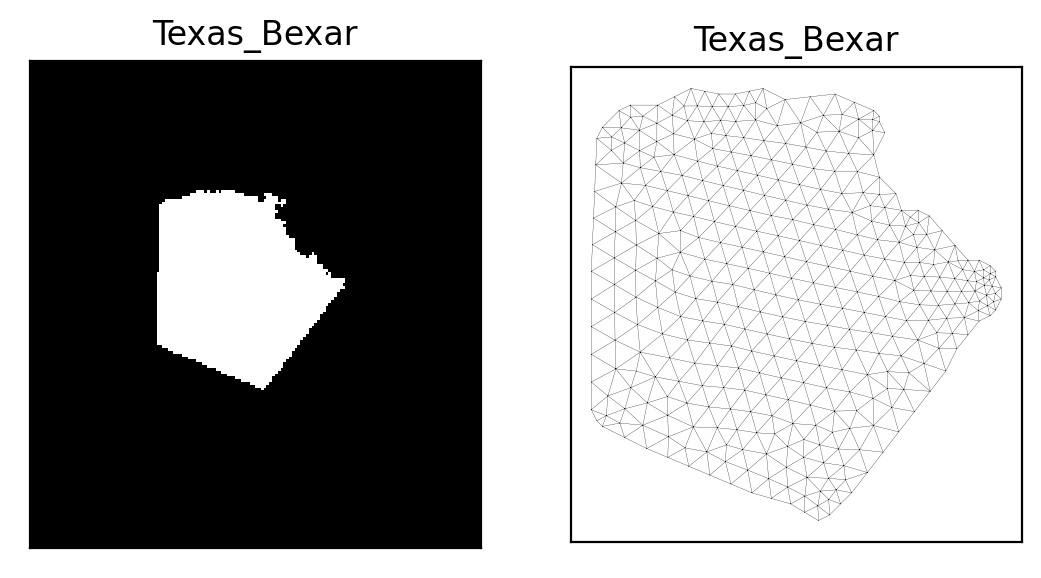

In [30]:
make_mesh('Texas_Bexar')

(17, 2)
(116, 123) (17, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 50%] Meshing curve 8 (Line)
Info    : [ 50%] Meshing curve 9 (Line)
Info    : [ 60%] Meshing curve 10 (Line)
Info    : [ 60%] Meshing curve 11 (Line)
Info    : [ 70%] Meshing curve 12 (Line)
Info    : [ 80%] Meshing curve 13 (Line)
Info    : [ 80%] Meshing curve 14 (Line)
Info    : [ 90%] Meshing curve 15 (Line)
Info    : [ 90%] Meshing curve 16 (Line)
Info    : [100%] Meshing curve 17 (Line)
Info    : Done meshing 1D (Wall 0.00351809s, CPU 0.001086s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.01766s, CPU 0.017458s)
Info    : 478 nodes 971 elements


Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 478
  Number of cells:
    line: 77
    triangle: 877
    vertex: 17
Loaded dataset
Model training step 0.0338
Mesh is alright


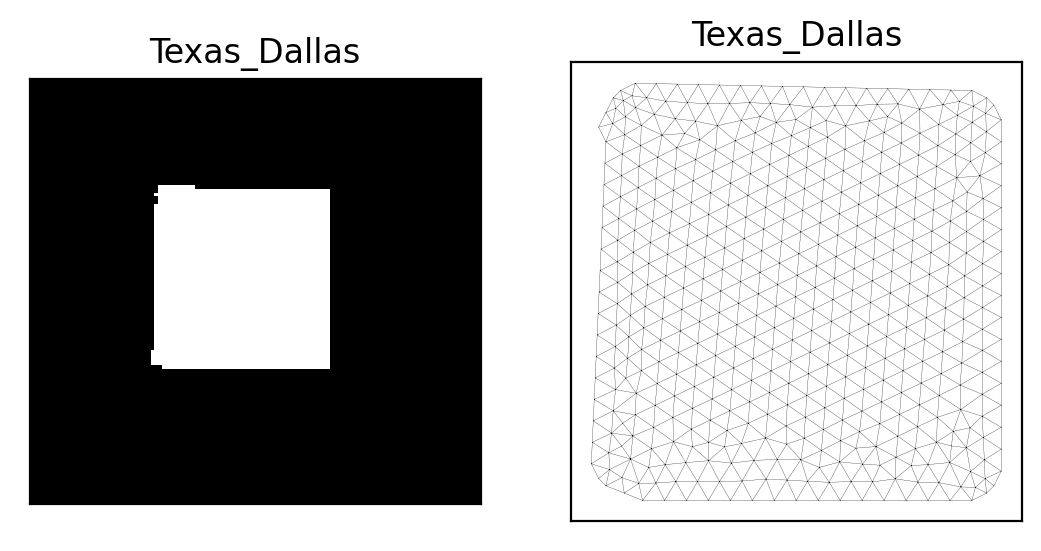

In [31]:
make_mesh('Texas_Dallas', mesh_size=3)

(73, 2)
(190, 235) (73, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 20%] Meshing curve 14 (Line)
Info    : [ 20%] Meshing curve 15 (Line)
Info    : [ 30%] Meshing curve 16 (Line)
Info    : [ 30%] Meshing curve 17 (Line)
Info    : [ 30%] Meshing curve 18 (Line)
Info    : [ 30%] Meshing curve 19 (Line)
Info    : [ 30%] Meshing curve 20 (Line)
Info    : [ 30%] Meshing curve 21 (Line)
Info    : [ 30%] Meshing curve 22 (Line)
Info    : [ 40%] Meshing curve 23 (Line)
Info    : [ 40%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 771
  Number of cells:
    line: 102
    triangle: 1438
    vertex: 73


Loaded dataset
Model training step 1.05e-05
Mesh is alright


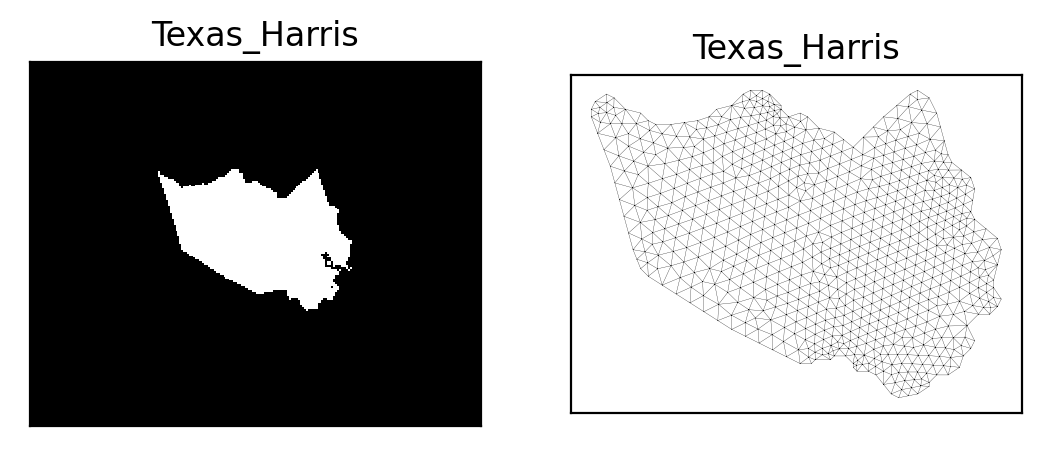

In [32]:
make_mesh('Texas_Harris')

(18, 2)
(134, 113) (18, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 40%] Meshing curve 8 (Line)
Info    : [ 50%] Meshing curve 9 (Line)
Info    : [ 50%] Meshing curve 10 (Line)
Info    : [ 60%] Meshing curve 11 (Line)
Info    : [ 70%] Meshing curve 12 (Line)
Info    : [ 70%] Meshing curve 13 (Line)
Info    : [ 80%] Meshing curve 14 (Line)
Info    : [ 80%] Meshing curve 15 (Line)
Info    : [ 90%] Meshing curve 16 (Line)
Info    : [ 90%] Meshing curve 17 (Line)
Info    : [100%] Meshing curve 18 (Line)
Info    : Done meshing 1D (Wall 0.00187306s, CPU 0.001834s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0198469s, CPU 0.010504s)
Info    : 311 nodes 638

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 311
  Number of cells:
    line: 63
    triangle: 557
    vertex: 18
Loaded dataset
Model training step 0.0136
Mesh is alright


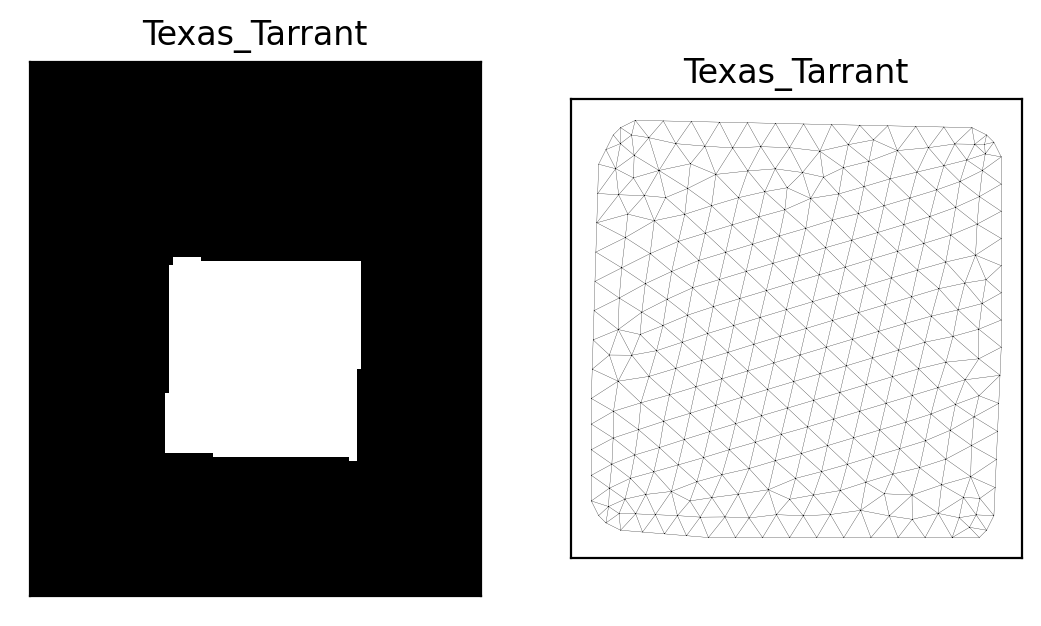

In [33]:
make_mesh('Texas_Tarrant', mesh_size=4)

(49, 2)
(150, 152) (49, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 30%] Meshing curve 14 (Line)
Info    : [ 30%] Meshing curve 15 (Line)
Info    : [ 40%] Meshing curve 16 (Line)
Info    : [ 40%] Meshing curve 17 (Line)
Info    : [ 40%] Meshing curve 18 (Line)
Info    : [ 40%] Meshing curve 19 (Line)
Info    : [ 40%] Meshing curve 20 (Line)
Info    : [ 50%] Meshing curve 21 (Line)
Info    : [ 50%] Meshing curve 22 (Line)
Info    : [ 50%] Meshing curve 23 (Line)
Info    : [ 50%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 418
  Number of cells:
    line: 68
    triangle: 766
    vertex: 49
Loaded dataset
Model training step 0.00174
Mesh is alright


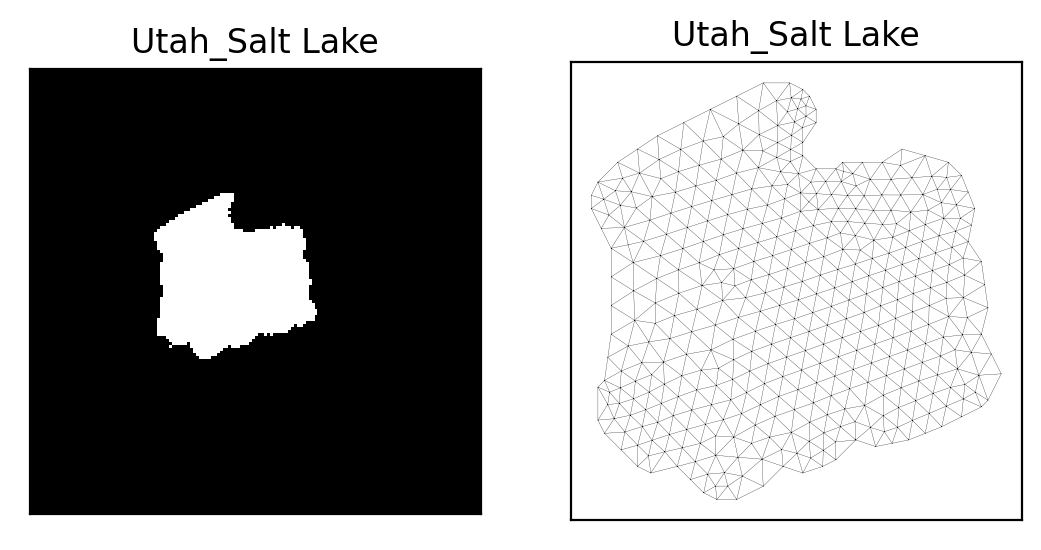

In [34]:
make_mesh('Utah_Salt Lake')

(46, 2)
(107, 104) (46, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 30%] Meshing curve 13 (Line)
Info    : [ 30%] Meshing curve 14 (Line)
Info    : [ 40%] Meshing curve 15 (Line)
Info    : [ 40%] Meshing curve 16 (Line)
Info    : [ 40%] Meshing curve 17 (Line)
Info    : [ 40%] Meshing curve 18 (Line)
Info    : [ 40%] Meshing curve 19 (Line)
Info    : [ 50%] Meshing curve 20 (Line)
Info    : [ 50%] Meshing curve 21 (Line)
Info    : [ 50%] Meshing curve 22 (Line)
Info    : [ 50%] Meshing curve 23 (Line)
Info    : [ 50%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 357
  Number of cells:
    line: 62
    triangle: 650
    vertex: 46
Loaded dataset
Model training step 0.00335
Mesh is alright


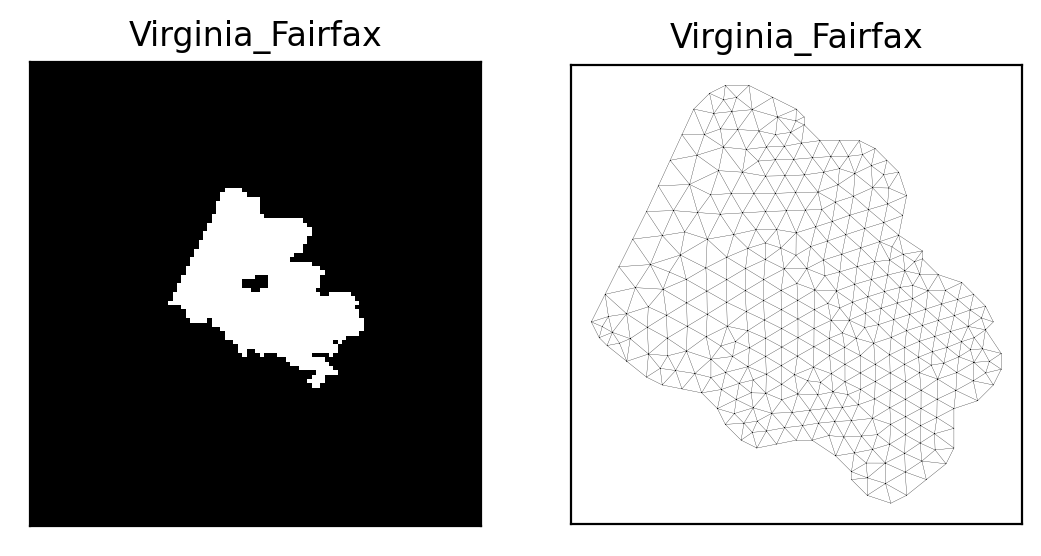

In [35]:
make_mesh('Virginia_Fairfax', mesh_size=4)

(91, 2)
(233, 276) (91, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 20%] Meshing curve 14 (Line)
Info    : [ 20%] Meshing curve 15 (Line)
Info    : [ 20%] Meshing curve 16 (Line)
Info    : [ 20%] Meshing curve 17 (Line)
Info    : [ 20%] Meshing curve 18 (Line)
Info    : [ 20%] Meshing curve 19 (Line)
Info    : [ 30%] Meshing curve 20 (Line)
Info    : [ 30%] Meshing curve 21 (Line)
Info    : [ 30%] Meshing curve 22 (Line)
Info    : [ 30%] Meshing curve 23 (Line)
Info    : [ 30%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 1061
  Number of cells:
    line: 120
    triangle: 2000
    vertex: 91
Loaded dataset
Model training step 0.00155
Mesh is alright


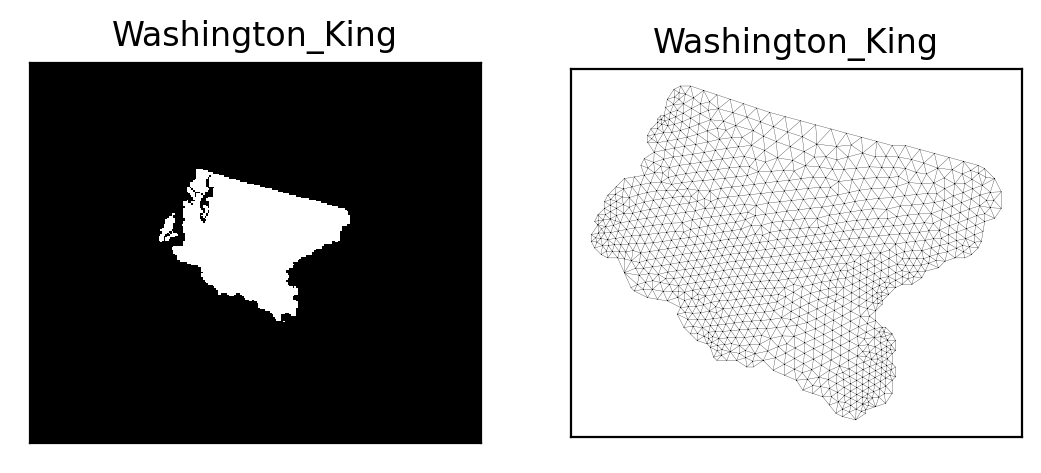

In [36]:
make_mesh('Washington_King')

(70, 2)
(182, 144) (70, 2)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 20%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 20%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 20%] Meshing curve 14 (Line)
Info    : [ 20%] Meshing curve 15 (Line)
Info    : [ 30%] Meshing curve 16 (Line)
Info    : [ 30%] Meshing curve 17 (Line)
Info    : [ 30%] Meshing curve 18 (Line)
Info    : [ 30%] Meshing curve 19 (Line)
Info    : [ 30%] Meshing curve 20 (Line)
Info    : [ 30%] Meshing curve 21 (Line)
Info    : [ 30%] Meshing curve 22 (Line)
Info    : [ 40%] Meshing curve 23 (Line)
Info    : [ 40%

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: DOLFIN XML can only handle one cell type at a time. Using triangle, discarding line, vertex.

<meshio mesh object>
  Number of points: 423
  Number of cells:
    line: 88
    triangle: 756
    vertex: 70
Loaded dataset
Model training step 0.015
Mesh is alright


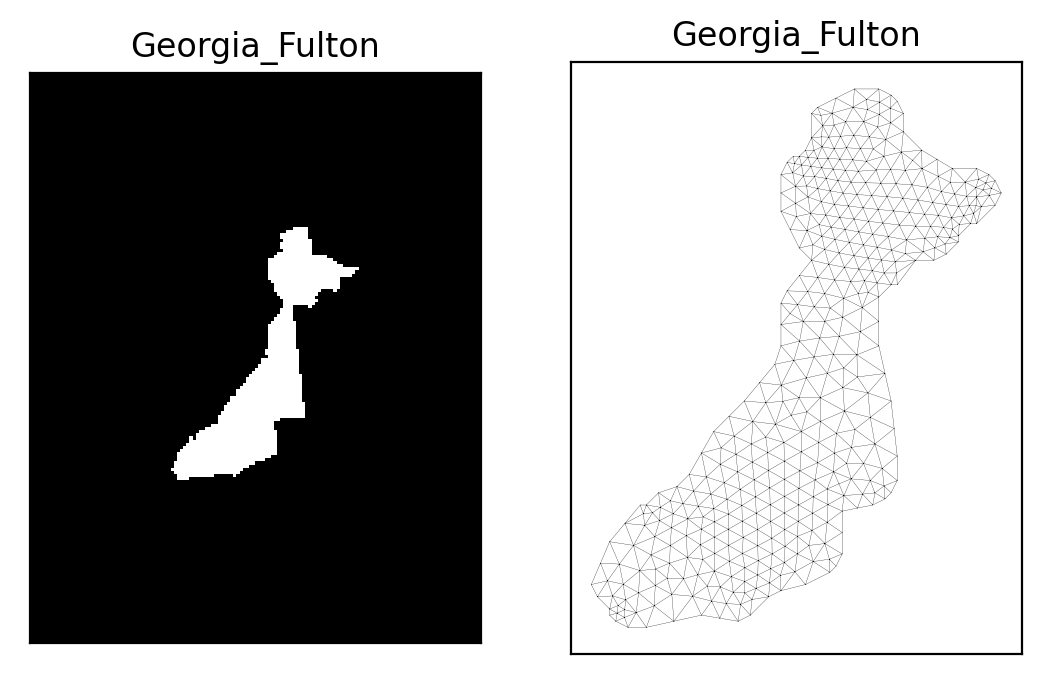

In [37]:
make_mesh('Georgia_Fulton')